<a href="https://colab.research.google.com/github/respect5716/Deep-Learning-Paper-Implementation/blob/master/06_Signal/AR-Net%20_%20A%20Simple%20Auto%20Regressive%20Neural%20Network%20for%20Time%20Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AR-Net _ A Simple Auto-Regressive Neural Network for Time-Series

## 0. Paper

### Info
* TItle : AR-Net _ A Simple Auto-Regressive Neural Network for Time-Series
* Author : Oskar J Triebe et al.
* Publication : [link](https://arxiv.org/abs/1911.12436)

### Summary
* Auto Regressive model을 neural network로 구현
* interpretable하고 큰 데이터에서도 효율적으로 학습할 수 있음

### Differences
* Dataset : Sampling -> Climate datatset, [link](https://www.tensorflow.org/tutorials/structured_data/time_series)
* hidden layer : False -> True

## 1. Setting

In [0]:
# Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [0]:
# Libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.arima_process import arma_generate_sample
import tensorflow as tf

In [3]:
# GPU Setting
!nvidia-smi

print(f'tensorflow version : {tf.__version__}')
print(f'available GPU list : {tf.config.list_physical_devices("GPU")}')

Sun Jun 14 09:17:38 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [0]:
# Hyperparameters
CONFIG = {
    'base_dir' : '/content/drive/Shared drives/Yoon/Project/Doing/Deep Learning Paper Implementation',
    'order' : 100,
    'learning_rate' : 0.001,
    'batch_size' : 32,
    'epoch_size' : 5
}

## 2. Data

In [0]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [0]:
df = pd.read_csv(csv_path)

In [23]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [24]:
df.shape

(420551, 15)

In [0]:
split_idx = 400000
train_data = df.iloc[:split_idx]
test_data = df.iloc[split_idx:]

In [0]:
class Dataset(tf.keras.utils.Sequence):
    def __init__(self, data, target, train):
        self.data = data[target]
        self.train = train
        self.on_epoch_end()
    
    def __len__(self):
        return np.ceil((len(self.data)-CONFIG['order']) / CONFIG['batch_size']).astype(np.int32)
    
    def on_epoch_end(self):
        if self.train == 'test':
            self.indices = np.arange(CONFIG['order'], len(self.data))
        else:
            self.indices = np.random.permutation(np.arange(CONFIG['order'], len(self.data)))

    def __getitem__(self, idx):
        batch_idx = self.indices[CONFIG['batch_size']*idx : CONFIG['batch_size']*(idx+1)]
        x_idx = [np.arange(i-CONFIG['order'], i) for i in batch_idx]
        x = np.stack([self.data.iloc[i] for i in x_idx])
        y = np.array(self.data.iloc[batch_idx])
        return x, y

In [117]:
train_dataset = Dataset(train_data, 'p (mbar)', 'train')
x, y = train_dataset.__getitem__(0)
x.shape, y.shape

((32, 100), (32,))

## 3. Model

In [0]:
def build_network():
    inputs = tf.keras.layers.Input((CONFIG['order'],))
    x = tf.keras.layers.Dense(CONFIG['order'], activation='relu')(inputs)
    outputs = tf.keras.layers.Dense(1, activation='linear')(x)

    network = tf.keras.Model(inputs, outputs)
    network.compile(
        loss = 'mse',
        optimizer = tf.keras.optimizers.Adam(CONFIG['learning_rate'])
    )
    return network

In [119]:
network = build_network()
network.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_12 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 101       
Total params: 10,201
Trainable params: 10,201
Non-trainable params: 0
_________________________________________________________________


## 4. Train

In [120]:
history = network.fit(
    train_dataset,
    epochs = CONFIG['epoch_size']
)

Epoch 1/5
12497/12497 [==============================] - 81s 6ms/step - loss: 913.9576
Epoch 2/5
12497/12497 [==============================] - 80s 6ms/step - loss: 62.8159
Epoch 3/5
12497/12497 [==============================] - 80s 6ms/step - loss: 21.9466
Epoch 4/5
12497/12497 [==============================] - 80s 6ms/step - loss: 9.9432
Epoch 5/5
12497/12497 [==============================] - 81s 6ms/step - loss: 5.7382


## 5. Test

In [0]:
pred_trajectory = []
inputs = np.array(train_data.iloc[-CONFIG['order']:]['p (mbar)'])[None,:]

for i in range(len(test_data)):
    pred = network(inputs)[0][0].numpy()
    pred_trajectory.append(pred)
    inputs[0] = np.append(inputs[0][1:], pred)

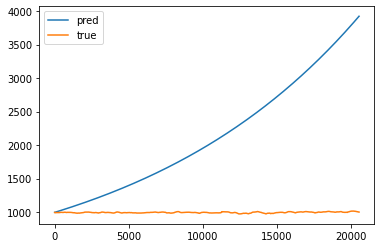

In [122]:
plt.plot(pred_trajectory)
plt.plot(test_data['p (mbar)'].values)
plt.legend(['pred', 'true'])
plt.show()